In [1]:
#!pip install -U tensorflow-addons

In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

2023-10-29 10:54:43.624927: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 10:54:43.650645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 10:54:43.965687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/littlepenguin/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a plan

In [207]:
CSV_HEADER = [
    "text",
    "label",
]

In [211]:
df = pd.read_csv('movie_no_header.csv',sep=',', header=None, names=CSV_HEADER)

df.shape

(40000, 2)

In [212]:
target = df['label']

In [213]:
df[['text']].isna().sum()

text    0
dtype: int64

In [214]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_y, test_y = train_test_split(df, target, test_size=0.3, random_state=42)

In [215]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (28000, 2)
Test dataset shape: (12000, 2)


In [216]:
print(train_data.iloc[0])

text     Awful, simply awful. It proves my theory about...
label                                                    0
Name: 38015, dtype: object


In [217]:
print(test_data.iloc[0])

text     The central theme in this movie seems to be co...
label                                                    0
Name: 32823, dtype: object


In [218]:
# Storing the training and test data in separate CSV files.

train_data_file = "train_movie_data.csv"
test_data_file = "test_movie_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

# Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.

# THIS IS WHERE THE PROBLEM HAPPENS...

The block below should be using the train dataset.  Because the dataset has mostly unique reviews, the test dataset wasn't included in the vocabulary
and causing errors.  I changed it to get the vocabulary from the whole dataset.  However, anything it learns in the dataset doesn't help in the validation set.  

This seems to be a model that only works on categorical values that have a finite set of categories.  

I can redo this with the census data or some other dataset we used in class (airbnb), but the movie reviews will not yield anything.

In [293]:
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "text": sorted(list(df["text"].unique())),
}

In [294]:
CATEGORICAL_FEATURES_WITH_VOCABULARY

{'text': ['!!!! MILD SPOILERS !!!!<br /><br />The premise goes like this : A store gets burnt down and assistant Sergio is asked by the father of the man who started the fire to take the wrap to which Sergio agrees .<br /><br />So far so good , but there`s a fair lapse of logic involved Sergio agrees to do this for the sum of 25,000 dollars but why ? Come on guys if you were a good looking white boy would you run the risk of getting a long spell in a tough jail ( A very real possibilty for arson ) for the sake of 25 grand ? I know I wouldn`t , and seeing as you`d have a criminal record no employer would want to touch you with a barge pole so is $25,000 dollars all that much for a life of workfare and welfare cheques ? There`s also something else that seems to have gone without notice from the premise , since Mister Lumpke has told Sergio that his son did the fire he seems unware of the possibility that he may know too much . Wouldn`t alarm bells be ringing in your mind about someone wa

In [295]:
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

In [296]:
CATEGORICAL_FEATURE_NAMES

['text']

In [297]:
#Get the first vocabulary entry
CATEGORICAL_FEATURES_WITH_VOCABULARY["text"][0]

'!!!! MILD SPOILERS !!!!<br /><br />The premise goes like this : A store gets burnt down and assistant Sergio is asked by the father of the man who started the fire to take the wrap to which Sergio agrees .<br /><br />So far so good , but there`s a fair lapse of logic involved Sergio agrees to do this for the sum of 25,000 dollars but why ? Come on guys if you were a good looking white boy would you run the risk of getting a long spell in a tough jail ( A very real possibilty for arson ) for the sake of 25 grand ? I know I wouldn`t , and seeing as you`d have a criminal record no employer would want to touch you with a barge pole so is $25,000 dollars all that much for a life of workfare and welfare cheques ? There`s also something else that seems to have gone without notice from the premise , since Mister Lumpke has told Sergio that his son did the fire he seems unware of the possibility that he may know too much . Wouldn`t alarm bells be ringing in your mind about someone wanting to k

In [298]:
#Get the last vocabulary entry
CATEGORICAL_FEATURES_WITH_VOCABULARY["text"][-1]

'ý thýnk uzak ýs the one of the best films of all times and everybody must realize this movie.I m a Turkish boy and a big cinema fun. and in this days our cinema industry is highing up.And UZAK is the best Turkish film of last ten years.and maybe one of the best films of all times.director nuri bilge ceylan is quite amazing.telling story,characters,atmosphere is wonderful.he is a minimalist director and tells about routine event family,dreams,expects,life.tells about you ,tells about me,tells about us.I promise you will find a piece of your body in this movie.cinema life welcomes a new director.he is waiting to realize.I promise yo you will love this movie please watch it'

In [299]:
# A list of all the input features.

#FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES 
# Removing the numeric feature since we only have categorical feature names
FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES

In [300]:
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    ["NA"]
    for feature_name in CSV_HEADER
]

In [301]:
# The name of the target feature.
TARGET_FEATURE_NAME = "label"

In [302]:
# A list of the labels of the target features.
TARGET_LABELS = ["0","1"]

# Configure the hyperparameters

The hyperparameters includes model architecture and training configurations.

In [435]:
LEARNING_RATE = 0.001 #0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2 #0.2
BATCH_SIZE = 265 #265
NUM_EPOCHS = 15 #15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    #2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

# Implement data reading pipeline

We define an input function that reads and parses the file, then converts features and labels into atf.data.Dataset for training or evaluation.

In [436]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


/home/littlepenguin/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [437]:


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    #weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index#, weights


In [438]:
def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

# Implement a training and evaluation procedure

In [439]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

# Create model inputs

Now, define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.

In [440]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        #if feature_name in NUMERIC_FEATURE_NAMES:
        #    inputs[feature_name] = layers.Input(
        #        name=feature_name, shape=(), dtype=tf.float32
        #    )
        #else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

# Encode features

The encode_inputs method returns encoded_categorical_feature_list and numerical_feature_list. We encode the categorical features as embeddings, using a fixed embedding_dims for all the features, regardless their vocabulary sizes. This is required for the Transformer model.
In this example, we only have one categorical feature and no numerical feature so that section is commented out

In [441]:
# Since we don't have numerical features, commenting that section out
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    #numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        #else:

            # Use the numerical features as-is.
            #numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            #numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list#, numerical_feature_list

# Implement an MLP block

In [442]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

# Experiment 1: a baseline model

In the first experiment, we create a simple multi-layer feed-forward network.

In [443]:
# !pip install pydot

# Follow instructions to install graphviz: https://graphviz.gitlab.io/download/

Total model weights: 636529


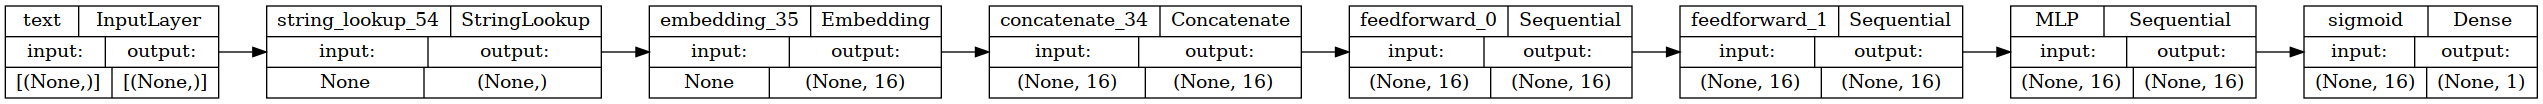

In [444]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    #encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
    encoded_categorical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list #+ numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

# Double click to maximize

In [445]:
# Let's train and evaluate the baseline model:

history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    104/Unknown - 2s 13ms/step - loss: 0.8450 - accuracy: 0.5008

2023-10-29 12:56:47.988887: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18188395899369949331
2023-10-29 12:56:47.988909: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15271275556643423131
2023-10-29 12:56:47.988913: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7876059770460727171
2023-10-29 12:56:47.988917: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3187001972469745684
2023-10-29 12:56:47.988919: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10532621443765222210


106/106 [==============================] - 2s 16ms/step - loss: 0.8436 - accuracy: 0.5010 - val_loss: 0.7006 - val_accuracy: 0.5073
Epoch 2/15
 11/106 [==>...........................] - ETA: 1s - loss: 0.7342 - accuracy: 0.5204

2023-10-29 12:56:48.296527: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14653965938386309493
2023-10-29 12:56:48.296547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3632382383443557223


106/106 [==============================] - 1s 13ms/step - loss: 0.7148 - accuracy: 0.5481 - val_loss: 0.7025 - val_accuracy: 0.5091
Epoch 3/15
106/106 [==============================] - 1s 14ms/step - loss: 0.6557 - accuracy: 0.6123 - val_loss: 0.7401 - val_accuracy: 0.5075
Epoch 4/15
106/106 [==============================] - 1s 13ms/step - loss: 0.5274 - accuracy: 0.7322 - val_loss: 0.8846 - val_accuracy: 0.5107
Epoch 5/15
106/106 [==============================] - 1s 13ms/step - loss: 0.3427 - accuracy: 0.8526 - val_loss: 1.1843 - val_accuracy: 0.5119
Epoch 6/15
106/106 [==============================] - 1s 13ms/step - loss: 0.1921 - accuracy: 0.9286 - val_loss: 1.4913 - val_accuracy: 0.5121
Epoch 7/15
106/106 [==============================] - 1s 13ms/step - loss: 0.1050 - accuracy: 0.9639 - val_loss: 1.8120 - val_accuracy: 0.5128
Epoch 8/15
106/106 [==============================] - 1s 13ms/step - loss: 0.0656 - accuracy: 0.9792 - val_loss: 2.1000 - val_accuracy: 0.5147
Epoch 9/15

2023-10-29 12:57:08.001578: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14653965938386309493
2023-10-29 12:57:08.001604: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3632382383443557223


The baseline linear model achieves ~51.53% validation accuracy.

# Experiment 2: TabTransformer

The TabTransformer architecture works as follows:model.

  1) All the categorical features are encoded as embeddings, using the same embedding_dims. This means that each value in each categorical feature will have its own embedding vector.

  2) A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.

  3) The embedded categorical features are fed into a stack of Transformer blocks. Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.

  4) The outputs of the final Transformer layer, which are the contextual embeddings of the categorical features, are concatenated with the input numerical features, and fed into a final MLP block.

  5) A softmax classifer is applied at the end of the model.

/home/littlepenguin/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Total model weights: 649937


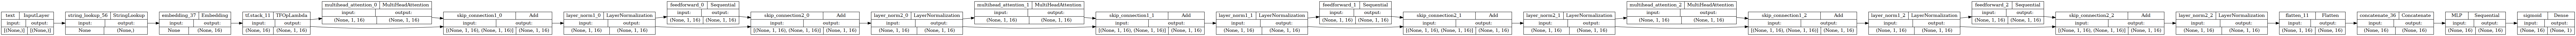

In [448]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    #encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
    encoded_categorical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
   # numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    #numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    #features = layers.concatenate([categorical_features, numerical_features])
    features = layers.concatenate([categorical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [449]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    105/Unknown - 3s 14ms/step - loss: 0.7625 - accuracy: 0.4999

2023-10-29 12:58:07.221381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11325342168935224028
2023-10-29 12:58:07.221411: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4693007922334079568


106/106 [==============================] - 3s 18ms/step - loss: 0.7622 - accuracy: 0.4999 - val_loss: 0.6957 - val_accuracy: 0.5029
Epoch 2/15
  9/106 [=>............................] - ETA: 1s - loss: 0.7120 - accuracy: 0.5166

2023-10-29 12:58:07.644202: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9509937147028793126
2023-10-29 12:58:07.644229: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6926615572174514997


106/106 [==============================] - 2s 16ms/step - loss: 0.6927 - accuracy: 0.5547 - val_loss: 0.7297 - val_accuracy: 0.4971
Epoch 3/15
106/106 [==============================] - 2s 15ms/step - loss: 0.5433 - accuracy: 0.7043 - val_loss: 1.0656 - val_accuracy: 0.5061
Epoch 4/15
106/106 [==============================] - 2s 16ms/step - loss: 0.2436 - accuracy: 0.8969 - val_loss: 1.8994 - val_accuracy: 0.5108
Epoch 5/15
106/106 [==============================] - 2s 16ms/step - loss: 0.0616 - accuracy: 0.9806 - val_loss: 2.3707 - val_accuracy: 0.5094
Epoch 6/15
106/106 [==============================] - 2s 16ms/step - loss: 0.0159 - accuracy: 0.9964 - val_loss: 2.7291 - val_accuracy: 0.5104
Epoch 7/15
106/106 [==============================] - 2s 16ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 2.9401 - val_accuracy: 0.5101
Epoch 8/15
106/106 [==============================] - 2s 16ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 3.1434 - val_accuracy: 0.5098
Epoch 9/15

2023-10-29 12:58:31.131670: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6926615572174514997
2023-10-29 12:58:31.131690: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15484371755979041665
2023-10-29 12:58:31.131695: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9433716843749144437
2023-10-29 12:58:31.131724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10975627581504060326
2023-10-29 12:58:31.131741: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 5518117450038660674
2023-10-29 12:58:31.131746: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 12873379422101229478


The TabTransformer model achieves ~50.92% validation accuracy.  This is slightly worse than the baseline model